## 项目-分析A/B测试结果

### 简介

通过分析电子商务网站运行的 A/B 测试的结果，来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面。

In [1]:
# 导入库
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [2]:
# 导入ab_data.csv数据，并将其存储在df中，查看前几行数据
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### 处理数据

In [3]:
# 查看缺失值
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [4]:
# new_page与treatment不一致的次数
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [5]:
# 删除new_page与treatment不一致的数据
df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index,inplace=True)

In [6]:
# 查看重复user_id
df.duplicated(subset='user_id').sum()

1

In [7]:
# 删除重复user_id
df.drop_duplicates(subset='user_id',inplace=True)

### 假设检验

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$


In [8]:
# 选取样本进行放回抽样，重复10000次，并将new_mean - old_mean值存入列表p_diffs中
sample_df = df.sample(20000)
p_diffs = []
for i in range(10000):
    boots_sample = sample_df.sample(20000,replace=True)
    old_mean = boots_sample[boots_sample['group'] == 'control']['converted'].mean()
    new_mean = boots_sample[boots_sample['group'] == 'treatment']['converted'].mean()
    p_diffs.append(new_mean - old_mean)

In [9]:
# 用假设均值0和抽样分布的标准差对正态分布的抽取值进行模拟
null_vals = np.random.normal(0,np.std(p_diffs),10000)

In [10]:
# 观测值
obs_diff = sample_df[sample_df['group'] == 'treatment']['converted'].mean() - sample_df[sample_df['group'] == 'control']['converted'].mean()
obs_diff

-0.0032904858733928816

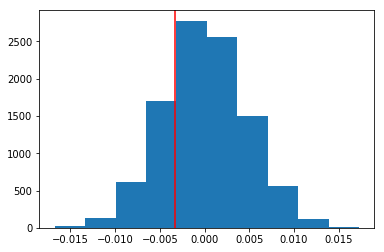

In [12]:
# null_vals分布直方图
plt.hist(null_vals);
plt.axvline(obs_diff,color='red');

In [12]:
# p值
p_val = (null_vals > obs_diff).mean()
p_val

0.7642

### 逻辑回归

In [13]:
# 添加一个截距列，一个ab_page列，当用户接收treatment时为1， control时为0
df['intercept'] = 1
df[['control','ab_page']] = pd.get_dummies(df['group'])
df = df.drop('control',axis=1)

In [16]:
# 建立模型，显示结果
logit_mod = sm.Logit(df['converted'], df[['intercept','ab_page']])
logit_mod.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        08:11:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### 结论

假定类型I错误率为5％

假设试验中p_val > 0.05，不拒绝零假设；

逻辑回归中，与回归模型对应的零假设是转化率与新旧页面不相关，备择假设是转化率至少与新旧页面之一相关；可以看出与ab_page关联的p值是0.19，同样大于0.05，不拒绝零假设，转化率与新旧页面不相关；

通过以上对A/B测试结果的分析，不推荐这家电子商务网站发布新页面